# Install libraries

In [ ]:
!pip install evalml
!pip install pandas-profiling

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import evalml
from evalml import AutoMLSearch
import logging
import os

2021-08-21 11:07:59,071 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


# Load Dataset

In [2]:
train_data=pd.read_csv("Dataset/Train.csv")
test_data=pd.read_csv("Dataset/Test.csv")

In [3]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA

In [4]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Using Pandas Profiling for EDA

In [6]:
profile=ProfileReport(train_data,title="Stores Sales Analysis",explorative=True)

### Save EDA report to html file

In [7]:
profile.to_file("EDA Report.html")

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
profile.to_notebook_iframe()

# Data Pre-processing

## 1. Data Blending

In [9]:
#join train and test dataset
#create source column having train and test values to perform train test split later
train_data["source"]="train"
test_data["source"]="test"

data=pd.concat([train_data,test_data],ignore_index=True)

In [10]:
print("Train dataset shape-",train_data.shape)
print("Test dataset shape-",test_data.shape)
print("Combine dataset shape-",data.shape)

Train dataset shape- (8523, 13)
Test dataset shape- (5681, 12)
Combine dataset shape- (14204, 13)


In [11]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [12]:
data.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
14199,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,test
14200,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,test
14201,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test
14202,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,test
14203,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test


## 2. Missing values handling

In [13]:
#Number of Null values in Dataset
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [14]:
#Percentage of null values in dataset
data.isnull().sum()/data.shape[0]*100

Item_Identifier               0.000000
Item_Weight                  17.171219
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
source                        0.000000
dtype: float64

#### In Item_Outlet_Sales there are 39.99% of null values due to concatenation of train and test data so no need to process it.

### Filling null values of Item_Weight and Outlet_Size 

#### Filling null values of Item_Weight
Check for outliers if present fill null values with median else fill with mean

<AxesSubplot:>

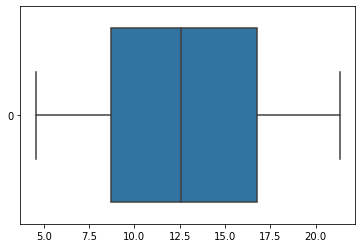

In [15]:
sns.boxplot(data=data["Item_Weight"],orient="h")

#### No outliers in Item_Weight so we can fill null values with mean

#### For better accuracy fill null values of Item_Weight with mean corresponding to Item_Identifire

In [16]:
data["Item_Identifier"].unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

In [17]:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

In [18]:
item_avg_weight

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


#### Define Function to compute weights

In [19]:
def compute_weights(cols):
    weight=cols[0]
    identifier=cols[1]
    
    if pd.isnull(weight):
        return item_avg_weight["Item_Weight"][item_avg_weight.index==identifier]
    else:
        return weight

In [20]:
# Filling null values of Item_Weight with mean
data["Item_Weight"]=data[["Item_Weight","Item_Identifier"]].apply(compute_weights,axis=1).astype(float)

In [21]:
data["Item_Weight"].isnull().sum()

0

##### No null values in Item Weight

### Fill Null values of Outlet_Size with mode
Outlet_Size depends on Outlet_Type so fill Outlet_Size corresponding to Outlet_Type

In [22]:
outlet_size_mode=data.pivot_table(values="Outlet_Size",columns="Outlet_Type",aggfunc=lambda x:x.mode())
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [23]:
#Define Function to compute outlet size

def compute_size_mode(cols):
    size=cols[0]
    Type=cols[1]
    
    if pd.isnull(size):
        return outlet_size_mode.loc["Outlet_Size"][outlet_size_mode.columns==Type][0]
    else:
        return size

In [24]:
#Fill null values with mode

data["Outlet_Size"]=data[["Outlet_Size","Outlet_Type"]].apply(compute_size_mode,axis=1)

In [25]:
data["Outlet_Size"].isnull().sum()

0

#### No null values in Outlet_Size

# Feature Engineering

### According to EDA report Item_Visibility has 526 (6.2%) zeros 
In our dataset minimum value of Item visibility is zero.Which not make any sense.Every product should be visible  to client.so compute it with mean value.

In [26]:
visibility_item_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')
visibility_item_avg

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799
...,...
NCZ30,0.027302
NCZ41,0.056396
NCZ42,0.011015


In [27]:
# def function to compute mean value of item_Visibility according to Item_Itentifier

def compute_visibility_mean(cols):
    visibility=cols[0]
    identifier=cols[1]
    
    if visibility==0:
        return visibility_item_avg["Item_Visibility"][visibility_item_avg.index==identifier]
    else:
        return visibility

In [28]:
#Compute visibilty values
data["Item_Visibility"]=data[["Item_Visibility","Item_Identifier"]].apply(
                            compute_visibility_mean,axis=1).astype(float)

In [29]:
sum(data.Item_Visibility==0)

0

### Years of operation of a store
The data is from 2013 so we need to consider that in calculations

In [30]:
data["Outlet_Years"]=2013-data["Outlet_Establishment_Year"]

In [31]:
data["Outlet_Years"].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### Create a broad category of Item_Type

In [32]:
data["Item_Type_Combined"]=data["Item_Identifier"].apply(lambda x:x[0:2])

In [33]:
data["Item_Type_Combined"]=data["Item_Type_Combined"].map({"FD":"Food","NC":"Non-Consumable","DR":"Drinks"})

In [34]:
data["Item_Type_Combined"].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### Change categories of Item_Fat_Content
Replacing values of LF and low fat with Low Fat and reg with Regular

In [35]:
data["Item_Fat_Content"]=data["Item_Fat_Content"].replace({"LF":"Low Fat","low fat":"Low Fat","reg":"Regular"})

In [36]:
data["Item_Fat_Content"].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

#### There are some non consumable that should not be included in Low Fat,fat content so replace them in Non-Edible 

In [37]:
data.loc[data["Item_Type_Combined"]=="Non-Consumable","Item_Fat_Content"]="Non-Edible"

In [38]:
data["Item_Fat_Content"].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

# Feature Transformations

#### The products that are more visible are likely to have higher sales so create new variable Item_Visibility_MeanRatio


In [39]:
item_visibility_func=lambda x: x["Item_Visibility"]/visibility_item_avg["Item_Visibility"][visibility_item_avg.index==x["Item_Identifier"]][0]
data["Item_Visibility_MeanRatio"]=data.apply(item_visibility_func,axis=1).astype(float)

In [40]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Type_Combined,Item_Visibility_MeanRatio
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,14,Food,0.931078
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,4,Drinks,0.933420
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,14,Food,0.960069
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,15,Food,1.000000
4,NCD19,8.93,Non-Edible,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,26,Non-Consumable,1.000000


In [41]:
data["Item_Visibility_MeanRatio"].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

## Handling Categorical Variables

In [42]:
le=LabelEncoder()

In [43]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'source', 'Outlet_Years',
       'Item_Type_Combined', 'Item_Visibility_MeanRatio'],
      dtype='object')

In [44]:
#Apply label Encoding to categorical variables
data["Outlet"]=le.fit_transform(data["Outlet_Identifier"])

In [45]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Type_Combined,Item_Visibility_MeanRatio,Outlet
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,14,Food,0.931078,9
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,4,Drinks,0.933420,3
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,14,Food,0.960069,9
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,15,Food,1.000000,0
4,NCD19,8.93,Non-Edible,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,26,Non-Consumable,1.000000,1


In [46]:
cat_var=["Item_Fat_Content","Outlet_Size","Outlet_Location_Type","Outlet_Type","Item_Type_Combined","Outlet"]
for i in cat_var:
    data[i]=le.fit_transform(data[i])

In [47]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Years,Item_Type_Combined,Item_Visibility_MeanRatio,Outlet
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,train,14,1,0.931078,9
1,DRC01,5.92,2,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,train,4,0,0.933420,3
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,train,14,1,0.960069,9
3,FDX07,19.20,2,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800,train,15,1,1.000000,0
4,NCD19,8.93,1,0.009780,Household,53.8614,OUT013,1987,0,2,1,994.7052,train,26,2,1.000000,1


In [48]:
"""
Item_Fat_Content-
                Low Fat=0
                Non-Edible=1
                Regular=2
Outlet_Size-
            High=0
            Medium=1
            Small=2

Outlet_Location_Type-
                    Tier 1=0
                    Tier 2=1
                    Tier 3=2
                    
Outlet_Type-
            Grocery Store=0
            Supermarket Type1=1
            Supermarket Type2=2
            Supermarket Type3=3

Item_Type_Combined-
                Drinks=0
                Food=1
                Non-Consumable=2
                
Outlet-
        OUT010=0
        OUT013=1
        OUT017=2
        OUT018=3
        OUT019=4
        OUT027=5
        OUT035=6
        OUT045=7
        OUT046=8
        OUT049=9
        
"""
pass

### Apply One Hot Encoding

In [49]:
data=pd.get_dummies(data,columns=["Item_Fat_Content","Outlet_Size","Outlet_Location_Type","Outlet_Type","Item_Type_Combined","Outlet"])

In [50]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Item_Outlet_Sales            float64
source                        object
Outlet_Years                   int64
Item_Visibility_MeanRatio    float64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

#### Drop unnecessary columns

In [51]:
data.drop(["Item_Identifier","Item_Type","Outlet_Identifier","Outlet_Establishment_Year"],axis=1,inplace=True)

## Data Partitioning

In [52]:
train_df=data.loc[data["source"]=="train"]
test_df=data.loc[data["source"]=="test"]

In [53]:
train_df.drop(["source"],axis=1,inplace=True)
test_df.drop(["source","Item_Outlet_Sales"],axis=1,inplace=True)

In [54]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Years,Item_Visibility_MeanRatio,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,9.30,0.016047,249.8092,3735.1380,14,0.931078,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,48.2692,443.4228,4,0.933420,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,141.6180,2097.2700,14,0.960069,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19.20,0.017834,182.0950,732.3800,15,1.000000,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0.009780,53.8614,994.7052,26,1.000000,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


In [55]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Visibility_MeanRatio,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
8523,20.750,0.007565,107.8622,14,1.029192,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8524,8.300,0.038428,87.3198,6,1.130311,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8525,14.600,0.099575,241.7538,15,1.735215,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8526,7.315,0.015388,155.0340,6,1.291577,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8527,13.600,0.118599,234.2300,28,0.917824,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


#### Save DataFrame in modified version

In [56]:
train_df.to_csv("Dataset/train_modified.csv",index=False)
test_df.to_csv("Dataset/test_modified.csv",index=False)

# Model Selection with EvalML

In [57]:
train=pd.read_csv("Dataset/train_modified.csv")

In [58]:
x_train=train.drop(["Item_Outlet_Sales"],axis=1)
y_train=train["Item_Outlet_Sales"]

In [59]:
x_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Visibility_MeanRatio,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,9.30,0.016047,249.8092,14,0.931078,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,5.92,0.019278,48.2692,4,0.933420,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0.016760,141.6180,14,0.960069,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,19.20,0.017834,182.0950,15,1.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0.009780,53.8614,26,1.000000,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [60]:
y_train.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

### Search for best regression model for our data with EvalML

In [61]:
automl = AutoMLSearch(X_train=x_train,y_train=y_train,problem_type="regression",objective="root mean squared error",optimize_thresholds=True)
automl.search()

Using default limit of max_batches=1.

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: linear_model, xgboost, random_forest, extra_trees, decision_tree, lightgbm, catboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1706.524

*****************************
* Evaluating Batch Number 1 *
*****************************

Linear Regressor w/ Log Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1141.976
Decision Tree Regressor w/ Log Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1132.656
Random Forest Regressor w/ Log Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1119.579
LightGBM Regressor w/ Log Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 1173.533
Elastic Net Regressor w/ Log Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross

In [62]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,Random Forest Regressor w/ Log Transformer + I...,3,1119.579109,23.277502,1140.187517,34.394169,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,7,Extra Trees Regressor w/ Log Transformer + Imp...,7,1121.126881,21.357932,1137.198533,34.303472,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,2,Decision Tree Regressor w/ Log Transformer + I...,2,1132.656337,25.057048,1157.709537,33.627862,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,6,XGBoost Regressor w/ Log Transformer + Imputer,6,1135.055596,27.995649,1156.058575,33.487268,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,5,Elastic Net Regressor w/ Log Transformer + Imp...,5,1141.923381,34.401254,1148.628429,33.084825,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,1,Linear Regressor w/ Log Transformer + Imputer ...,1,1141.976216,34.275783,1148.635125,33.081729,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,4,LightGBM Regressor w/ Log Transformer + Imputer,4,1173.533426,25.005453,1198.178341,31.232519,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,8,CatBoost Regressor w/ Log Transformer + Imputer,8,1660.024796,32.534618,1692.389114,2.724779,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mean Baseline Regression Pipeline,0,1706.523797,21.384488,1730.821110,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


### Getting best pipeline

In [63]:
automl.best_pipeline

pipeline = RegressionPipeline(component_graph={'Log Transformer': ['Log Transformer', 'X', 'y'], 'Imputer': ['Imputer', 'X', 'Log Transformer.y'], 'Random Forest Regressor': ['Random Forest Regressor', 'Imputer.x', 'Log Transformer.y']}, parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Regressor':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}, random_seed=0)

In [64]:
best_pipeline=automl.best_pipeline

### Discription of Pipeline

In [65]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


********************************************************
* Random Forest Regressor w/ Log Transformer + Imputer *
********************************************************

Problem Type: regression
Model Family: Random Forest

Pipeline Steps
1. Log Transformer
2. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
3. Random Forest Regressor
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for regression problems.
Total training time (including CV): 2.4 seconds

Cross Validation
----------------
             Root Mean Squared Error  ExpVariance  MaxError  MedianAE         MSE     MAE    R2 # Training # Validation
0                           1140.188        0.588  6663.757   502.765 1300027.575 785.671 0.566      5,682        2,841
1                           1124.219        0.580  6372.073   486.311 1263867.327 771.269 0.562      5,682        2,841
2         

In [66]:
best_pipeline.score(x_train,y_train,objectives=["root mean squared error","mse","mae","r2"])

OrderedDict([('Root Mean Squared Error', 1090.0603304482213),
             ('MSE', 1188231.5240168856),
             ('MAE', 746.4043319104551),
             ('R2', 0.5919253291041903)])

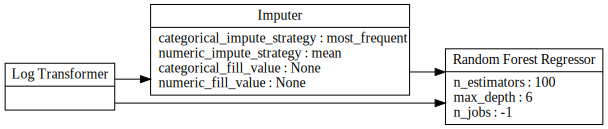

In [67]:
best_pipeline.graph()

In [68]:
# Create the Handler for logging records/messages to a file
file_handler = logging.FileHandler("log_file.log")

In [69]:
#set the format of the log records and the logging level to DEBUG
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG)

In [70]:
# a function  to create and save logs in the log files
def log(path, file):
    """[Create a log file to record the experiment's logs]
    
    Arguments:
        path {string} -- path to the directory
        file {string} -- file name
    
    Returns:
        [obj] -- [logger that record logs]
    """

    # check if the file exist
    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    # configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    # create a file handler for output file
    handler = logging.FileHandler(log_file)

    # set the logging level for log file
    handler.setLevel(logging.INFO)
    
    # create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    # add the handlers to the logger
    logger.addHandler(handler)

    return logger

In [71]:
logger = log(path=".",file="log_file.log")

In [72]:
logger.info("Start data training with random forest model")

2021-08-21 11:08:49,042 INFO:Start data training with random forest model


## Create Random Forest model with sklearn.
We can't use EvalML to production because its of large size and free tier services provide only 500MB data limit.And with EvalML it goes to 620MB.

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
reg_rf = RandomForestRegressor()
reg_rf.fit(x_train, y_train)
logger.info("Train {}".format("RandomForestRegressor"))

2021-08-21 11:08:53,564 INFO:Train RandomForestRegressor


In [75]:
reg_rf.score(x_train, y_train)

0.9385304184868033

In [76]:
y_pred=reg_rf.predict(x_train)

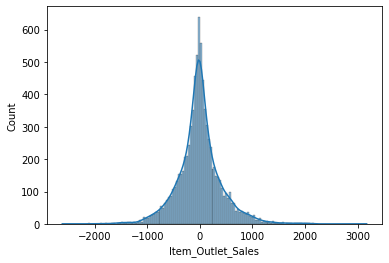

In [77]:
sns.histplot(y_train-y_pred,kde=True)
plt.show()

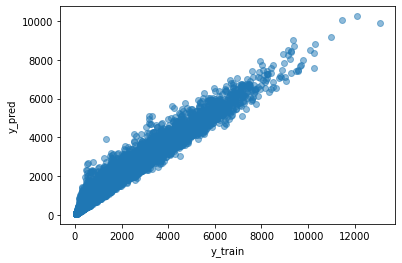

In [78]:
plt.scatter(y_train, y_pred, alpha = 0.5)
plt.xlabel("y_train")
plt.ylabel("y_pred")
plt.show()

In [79]:
from sklearn import metrics

In [80]:
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
logger.info("MAE: {}\n\t\t\t\t\t\t\t   MSE:{}\n\t\t\t\t\t\t\t   RMSE:{}".format(metrics.mean_absolute_error(y_train, y_pred),metrics.mean_squared_error(y_train, y_pred),np.sqrt(metrics.mean_squared_error(y_train, y_pred))))

2021-08-21 11:08:54,811 INFO:MAE: 293.174649675701
							   MSE:178987.08185383695
							   RMSE:423.06864910299953


MAE: 293.174649675701
MSE: 178987.08185383695
RMSE: 423.06864910299953


## Hyperparameter Tuning

    Choose following method for hyperparameter tuning
        RandomizedSearchCV --> Fast
        GridSearchCV
    Assign hyperparameters in form of dictionery
    Fit the model
    Check best paramters and best score

In [81]:
from sklearn.model_selection import RandomizedSearchCV

In [82]:
logger.info("-"*50)
logger.info("Start Hyper-Parameter Tuning")

2021-08-21 11:08:54,855 INFO:--------------------------------------------------
2021-08-21 11:08:54,860 INFO:Start Hyper-Parameter Tuning


In [83]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [84]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [85]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [86]:
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [87]:
logger.info(rf_random.fit(x_train,y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

2021-08-21 11:21:50,641 INFO:RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)


In [88]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 15}

In [89]:
logger.info("Best Paramteres:{}".format(rf_random.best_params_))

2021-08-21 11:21:50,781 INFO:Best Paramteres:{'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15}


In [90]:
prediction = rf_random.predict(x_train)

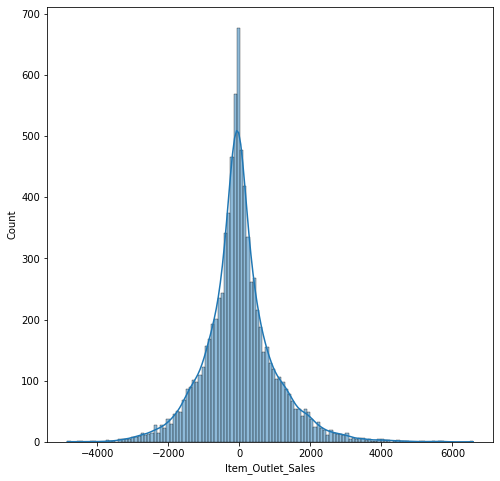

In [91]:
plt.figure(figsize = (8,8))
sns.histplot(y_train-prediction,kde=True)
plt.show()

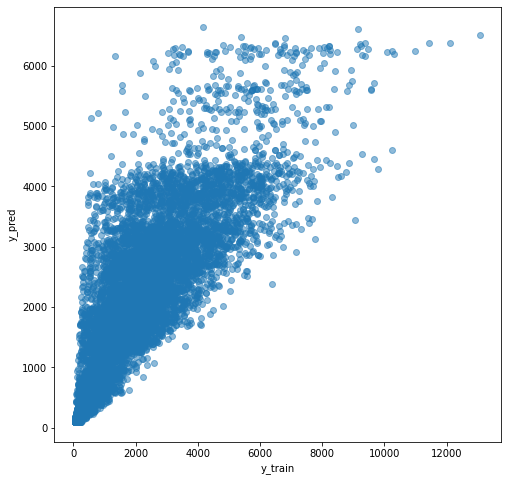

In [92]:
plt.figure(figsize = (8,8))
plt.scatter(y_train, prediction, alpha = 0.5)
plt.xlabel("y_train")
plt.ylabel("y_pred")
plt.show()

In [93]:
print('MAE:', metrics.mean_absolute_error(y_train, prediction))
print('MSE:', metrics.mean_squared_error(y_train, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, prediction)))
logger.info("MAE: {}\n\t\t\t\t\t\t\t   MSE:{}\n\t\t\t\t\t\t\t   RMSE:{}".format(metrics.mean_absolute_error(y_train, prediction),metrics.mean_squared_error(y_train, prediction),np.sqrt(metrics.mean_squared_error(y_train, prediction))))

2021-08-21 11:21:51,725 INFO:MAE: 704.5392387579475
							   MSE:1014635.6953508949
							   RMSE:1007.2912663926433


MAE: 704.5392387579475
MSE: 1014635.6953508949
RMSE: 1007.2912663926433


In [94]:
logger.info("-"*50)

2021-08-21 11:21:51,739 INFO:--------------------------------------------------


## Save the model to reuse it again.

In [95]:
import pickle
# open a file, where you want to store the data
file = open('rf_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)
file.close()

## Predicting test data

In [96]:
with open("rf_model.pkl","rb") as file1:
    model=pickle.load(file1)

In [97]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Visibility_MeanRatio,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
8523,20.750,0.007565,107.8622,14,1.029192,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8524,8.300,0.038428,87.3198,6,1.130311,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8525,14.600,0.099575,241.7538,15,1.735215,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8526,7.315,0.015388,155.0340,6,1.291577,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8527,13.600,0.118599,234.2300,28,0.917824,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [98]:
test_df['Item_Outlet_Sales'] = (model.predict(test_df)).tolist()

In [99]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Years,Item_Visibility_MeanRatio,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,Outlet_Size_1,...,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9,Item_Outlet_Sales
8523,20.750,0.007565,107.8622,14,1.029192,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1584.238413
8524,8.300,0.038428,87.3198,6,1.130311,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1277.330320
8525,14.600,0.099575,241.7538,15,1.735215,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,590.837956
8526,7.315,0.015388,155.0340,6,1.291577,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2403.304858
8527,13.600,0.118599,234.2300,28,0.917824,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,6175.965292


In [100]:
#Save Output dataframe in csv file
test_df.to_csv("Dataset/Test_Output.csv",index=False)